# Limitations of sklearn's Non-Negative Matrix Factorisation Library

In this assignment, we will build a recommender system using sklearn's non-negative matrix factorisation algorithm to predict movie ratings using a reformatted version of the 1 million ratings subset [MovieLens 1M](https://www.kaggle.com/odedgolden/movielens-1m-dataset).

1. Load the movie ratings data (as in the HW3-recommender-system) and use matrix factorisation technique(s) and predict the missing ratings from the test data. Measure the RMSE.
2. Discuss the results and why sklearn's non-negative matrix factorisation library did not work well compared to simple baseline or similarity-based methods we’ve done in Module 3. Can you suggest a way(s) to fix it?

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import namedtuple
from scipy.sparse import csr_matrix, csr_array
from sklearn.decomposition import MiniBatchNMF
from sklearn.metrics import mean_squared_error

C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


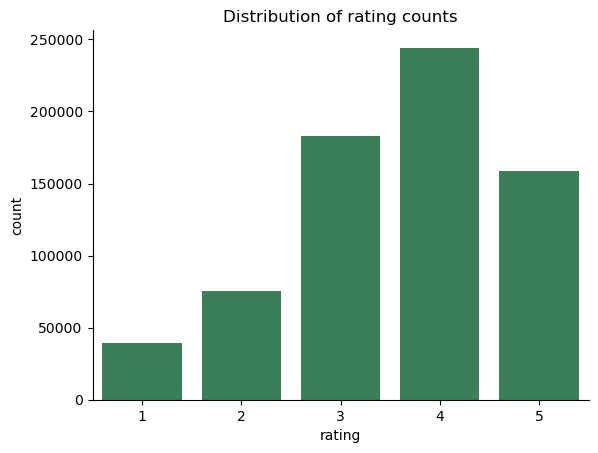

In [3]:
# load the data
MV_users = pd.read_csv('data/movielens-1m/users.csv')
MV_movies = pd.read_csv('data/movielens-1m/movies.csv')
train = pd.read_csv('data/movielens-1m/train.csv')
test = pd.read_csv('data/movielens-1m/test.csv')

MV_users.rename(columns={'accupation': 'occupation'}, inplace=True)

# unlike before, let's do a little EDA on the data
# most movies have been rated a 3, 4 or 5, with 4 the most common
sns.countplot(train, x="rating", color="seagreen")
plt.title("Distribution of rating counts")
sns.despine()

C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


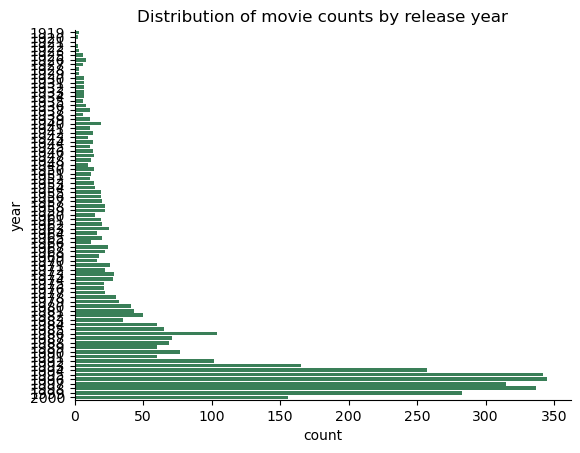

In [6]:
# it's probably unsurprising to find that there is a positive relationship between the count and release year
sns.countplot(MV_movies, y="year", color="seagreen")
plt.title("Distribution of movie counts by release year")
sns.despine()

C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


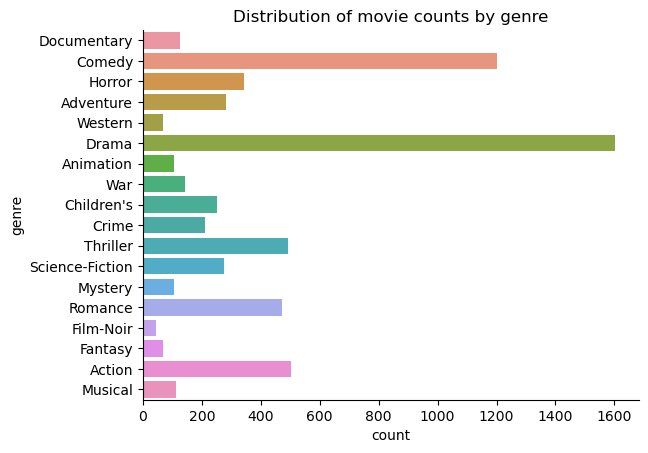

In [8]:
# after some manipulation, we can see that "Drama" and "Comedy" are the most common genre tags (a movie can have
# multiple genres) and "Film-Noir" and "Western" are the least-common tags
MV_movies_long = pd.melt(MV_movies, id_vars=['mID', 'title', 'year'], var_name='genre', value_name='count')
MV_movies_long = MV_movies_long.loc[MV_movies_long['count'] == 1, ]
MV_movies_long.drop('count', axis=1, inplace=True)

genre_dict = {'Doc': 'Documentary',
              'Com': 'Comedy',
              'Hor': 'Horror',
              'Adv': 'Adventure',
              'Wes': 'Western',
              'Dra': 'Drama',
              'Ani': 'Animation',
              'War': 'War',
              'Chi': "Children's",
              'Cri': 'Crime',
              'Thr': 'Thriller',
              'Sci': 'Science-Fiction',
              'Mys': 'Mystery',
              'Rom': 'Romance',
              'Fil': 'Film-Noir',
              'Fan': 'Fantasy',
              'Act': 'Action',
              'Mus': 'Musical'}
MV_movies_long['genre'] = MV_movies_long.genre.map(genre_dict)

sns.countplot(MV_movies_long, y="genre")
plt.title("Distribution of movie counts by genre")
sns.despine()

C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


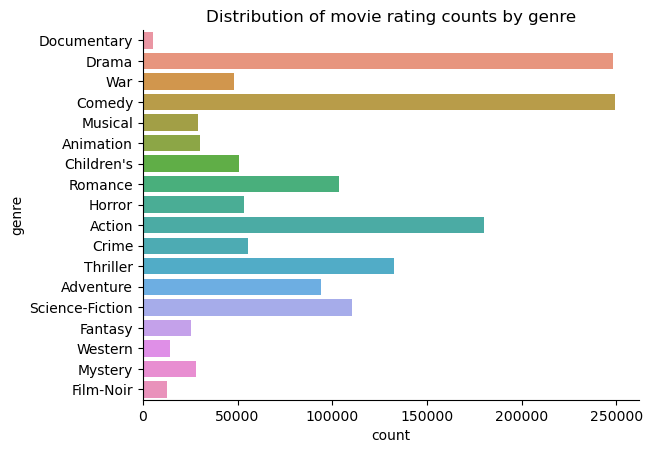

In [9]:
# the number of times each genre was rated is very similar to the overall genre counts
MV_movies_ratings = MV_movies_long.merge(train, on='mID')

sns.countplot(MV_movies_ratings, y="genre")
plt.title("Distribution of movie rating counts by genre")
sns.despine()

C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


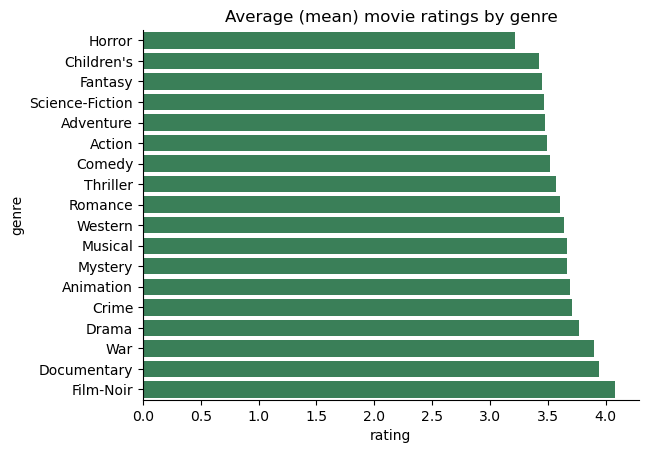

In [12]:
# ... but interestingly doesn't necessarily correlate with the average rating - in fact Documentaries and Film-Noir
# had the highest average rating and Horror and Children's the lowest
average_ratings = MV_movies_ratings.groupby('genre')['rating'].mean().reset_index()
average_ratings.sort_values(by='rating', inplace=True)

sns.barplot(average_ratings, x='rating', y='genre', color='seagreen')
plt.title("Average (mean) movie ratings by genre")
sns.despine()

C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


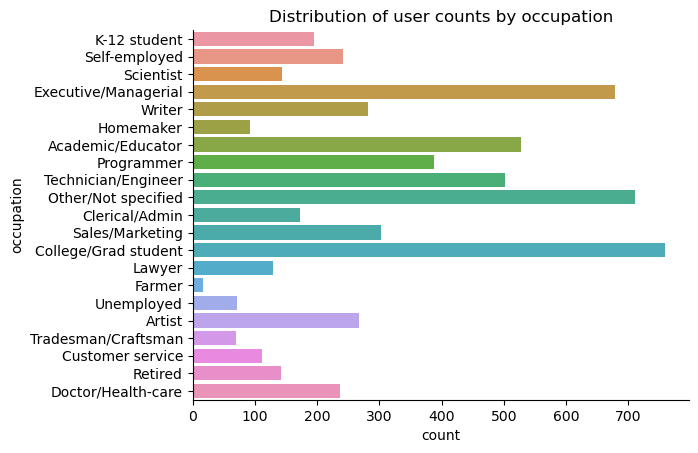

In [13]:
# the most common occupations in the dataset are Executive/Managerial, Other and College/Grad student. The least
# common occupation is Farmer
occupation_dict = {4: 'College/Grad student',
                   0: 'Other/Not specified',
                   7: 'Executive/Managerial',
                   1: 'Academic/Educator',
                   17: 'Technician/Engineer',
                   12: 'Programmer',
                   14: 'Sales/Marketing',
                   20: 'Writer',
                   2: 'Artist',
                   16: 'Self-employed',
                   6: 'Doctor/Health-care',
                   10: 'K-12 student',
                   3: 'Clerical/Admin',
                   15: 'Scientist',
                   13: 'Retired',
                   11: 'Lawyer',
                   5: 'Customer service',
                   9: 'Homemaker',
                   19: 'Unemployed',
                   18: 'Tradesman/Craftsman',
                   8: 'Farmer'}
MV_users['occupation'] = MV_users.occupation.map(occupation_dict)

sns.countplot(MV_users, y="occupation")
plt.title("Distribution of user counts by occupation")
sns.despine()

C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\anaconda3\envs\coursera-ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


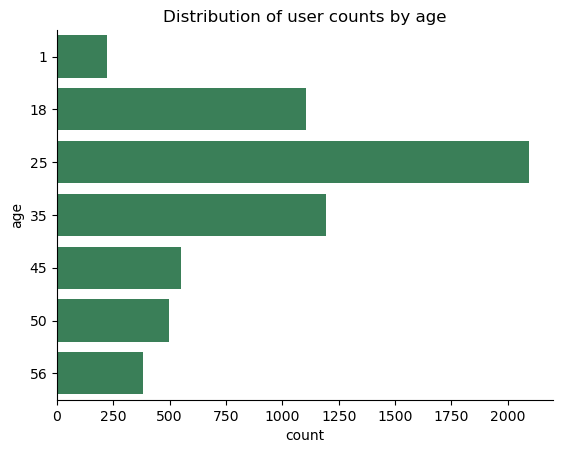

In [14]:
# the median age in the dataset are 25-34 year olds
sns.countplot(MV_users, y="age", color="seagreen")
plt.title("Distribution of user counts by age")
sns.despine()

In [ ]:
# define the NMF RecSys class
class NMFRecSys():
    def __init__(self, data):
        self.data = data
        self.allusers = list(self.data.users.uID)
        self.allmovies = list(self.data.movies.mID)
        self.mid2idx = dict(zip(self.data.movies.mID, list(range(len(self.data.movies)))))
        self.uid2idx = dict(zip(self.data.users.uID, list(range(len(self.data.users)))))
        self.Mr = self.rating_matrix()
        self.yt = self.test_rating_matrix()


    def rating_matrix(self, fill_value=0):
        """
        Generates a numpy ratings array using the training data.
        :return: Numpy array with shape (#allusers, #allmovies)
        """
        # explode into sparse matrices with user ids as the rows and movie ids as the columns
        ind_movie = [self.mid2idx[id] for id in self.data.train.mID]
        ind_user = [self.uid2idx[id] for id in self.data.train.uID]
        rating_train = list(self.data.train.rating)
        Mr = np.full(shape=(len(self.allusers), len(self.allmovies)), fill_value=fill_value)
        Mr[ind_user, ind_movie] = rating_train

        # assert that the generated ratings matrix and the check matrix are the same
        # note that it fails when the fill_value != 0
        if fill_value == 0:
            Mr_check = csr_matrix(self.data.train.pivot(index='uID', columns='mID', values='rating').fillna(fill_value))
            assert Mr.sum() == Mr_check.sum(), "Check ratings matrix!"
        else:
            pass

        return Mr


    def test_rating_matrix(self, fill_value=0):
        """
        Generates a numpy ratings array using the test data.
        :return: Numpy array with shape (#allusers, #allmovies)
        """
        # explode into sparse matrices with user ids as the rows and movie ids as the columns
        ind_movie = [self.mid2idx[id] for id in self.data.test.mID]
        ind_user = [self.uid2idx[id] for id in self.data.test.uID]
        rating_test = list(self.data.test.rating)
        yt = np.full(shape=(len(self.allusers), len(self.allmovies)), fill_value=fill_value)
        yt[ind_user, ind_movie] = rating_test

        # assert that the generated ratings matrix and the check matrix are the same
        if fill_value == 0:
            yt_check = csr_matrix(self.data.test.pivot(index='uID', columns='mID', values='rating').fillna(fill_value))
            assert yt.sum() == yt_check.sum(), "Check ratings matrix!"
        else:
            pass

        return yt


    def predict(self, num_features=20, init_method='nndsvd', max_iterations=500, batch_size=1024):
        """
        NMF was developed from PCA and is designed to extract sparse and significant features from a set of
        non-negative data factors. It decomposes a non-negative matrix (Mr) into its user (W) and movie (H) component
        matrices by optimising the distance between Mr and the matrix product of the component matrices. The most
        widely used distance measure (and the default in sklearn) is the squared Frobenius norm.
        The number of latent or hidden features must be pre-specified, and is the second dimension of the component
        matrices.

        :param num_features: The desired number of latent or hidden features for the component matrices W and H.
        :param init_method: Initialisation method. 'nnsvd' is better for sparseness, but 'nnsvda' or 'random' by default.
        :param max_iterations: Maximum number of iterations permitted.
        :param batch_size: Number of samples in each mini-batch. Larger batches provide better long-term convergence.
        :return: A sparse rating prediction array with shape (#allusers, #allmovies)
        """
        # model = NMF(n_components=num_features, init=init_method, random_state=42, max_iter=max_iterations)
        model = MiniBatchNMF(n_components=num_features, init=init_method, random_state=42, max_iter=max_iterations,
                             batch_size=batch_size)

        W = model.fit_transform(self.Mr)  # shape (#users, #latent features)
        H = model.components_  # shape (#latent features, #movies)

        # construct the prediction matrix
        yp = np.dot(W, H)
        # apply a threshold to coerce small values to be 0
        # yp[yp < 1] = 0
        yp = csr_array(yp)

        return yp


    def rmse(self, yp, fill_value=0):
        """
        Generate the RMSE of the test ratings data.
        :param yt: Actual ratings
        :param yp: Predicted ratings
        :return: RMSE score
        """

        # identify non-missing actual ratings in the dataset
        # non_missing_idx = yt.nonzero()
        non_missing_idx = (self.yt != fill_value).nonzero()
        rmse = np.sqrt(mean_squared_error(self.yt[non_missing_idx], yp[non_missing_idx]))

        return rmse

In [ ]:
# sample the data
sample_train = train[:30000]
sample_test = test[:30000]

# identify all the users and movies in the sampled training and testing data combined
sample_MV_users = MV_users[(MV_users.uID.isin(sample_train.uID)) | (MV_users.uID.isin(sample_test.uID))]
sample_MV_movies = MV_movies[(MV_movies.mID.isin(sample_train.mID)) | (MV_movies.mID.isin(sample_test.mID))]

sample_data = Data(sample_MV_users, sample_MV_movies, sample_train, sample_test)

# test on the sample data
sample_rs = NMFRecSys(sample_data)
sample_yp = sample_rs.predict(num_features=20)
print('RMSE:', round(sample_rs.rmse(sample_yp), 4))

In [ ]:
Data = namedtuple('Data', ['users', 'movies', 'train', 'test'])
data = Data(MV_users, MV_movies, train, test)

# run on the full data
rs = NMFRecSys(data)
yp = rs.predict(num_features=20)
print('RMSE:', round(rs.rmse(yp), 4))

Recall that the results from the previous recommender systems were:
|Method|RMSE sample|RMSE|
|:----|:--------:|:--:|
|Baseline, $Y_p=3$|1.2643|1.2586|
|Baseline, $Y_p=\mu_u$|1.1430|1.0353|
|Content based, item-item|1.1963|1.0128|
|Collaborative, cosine|1.1430|1.0263|
|Collaborative, jaccard, $M_r\geq 3$| |0.9819|
|Collaborative, jaccard, $M_r\geq 1$| |0.9914|
|Collaborative, jaccard, $M_r$| |0.9517|
|Collaborative, NMF, 0 fill|3.7307|2.9127|
|Collaborative, NMF, 3.5 fill|1.1220|1.0473|

The RMSE on the sample data was 3.7 and the RMSE on the full dataset was 2.9. NMF performs poorly because 'missing'
ratings are automatically set to 0, which is outside the range of valid values (1-5) and adversely affects the loss
Frobenius norm function. Changing the fill value to a non-zero value appeared to help immensely, but only insofar as
to become comparable with the baseline results.

The best solution to the problem would be to simply avoid including missing ratings data in the loss function
calculation, but this isn't possible using the current implementation of sklearn's NMF (or MiniBatchNMF) function.
Other things that could help at the marhins would be experimenting with increasing the number of components or
latent features retained and developing a more refined approach to imputing the missing ratings data.